In [1]:
import random

def generar_instancia(n, seed=None):
    if seed is not None:
        random.seed(seed)

    transacciones = []
    sospechoso = []

    for _ in range(n):
        t = random.randint(1000, 10000)
        e = random.randint(1, 100)
        transacciones.append((t, e))
        s = random.randint(t - e, t + e)
        sospechoso.append(s)

    return transacciones, sospechoso


In [2]:
def correr_algoritmo(transacciones, sospechoso):
    n = len(transacciones)
    intervalos = []

    for t, e in transacciones:
        minimo = t - e
        maximo = t + e
        intervalos.append((minimo, maximo, (t, e)))

    intervalos.sort(key=lambda x: x[1])

    coincidencias = []
    usados = set()

    for j in range(n):
        encontrado = False
        for i in range(n):
            inicio, fin, intervalo = intervalos[i]
            if i not in usados and inicio <= sospechoso[j] <= fin:
                coincidencias.append((intervalo, sospechoso[j]))
                usados.add(i)
                encontrado = True
                break
        if not encontrado:
            return False
    return True


In [4]:
from concurrent.futures import ProcessPoolExecutor, as_completed
import time
import os

# Este parámetro controla cuantas veces se ejecuta el algoritmo para cada
# tamaño. Esto es conveniente para reducir el error estadístico en la medición
# de tiempos. Al finalizar las ejecuciones, se promedian los tiempos obtenidos
RUNS_PER_SIZE = 10

# Ajustar este valor si se quiere usar más de un proceso para medir los tiempos
# de ejecución, o None para usar todos los procesadores disponibles. Si se usan
# varios procesos, tener cuidado con el uso de memoria del sistema.
MAX_WORKERS = max(1, (os.cpu_count() or 0) // 4)


def _time_run(algorithm, *args):
    start = time.time()
    algorithm(*args)
    return time.time() - start


def time_algorithm(algorithm, sizes, get_args):
    futures = {}
    total_times = {i: 0 for i in sizes}

    # Usa un ProcessPoolExecutor para ejecutar las mediciones en paralelo
    # (el ThreadPoolExecutor no sirve por el GIL de Python)
    with ProcessPoolExecutor(MAX_WORKERS) as p:
        for i in sizes:
            for _ in range(RUNS_PER_SIZE):
                futures[p.submit(_time_run, algorithm, *get_args(i))] = i

        for f in as_completed(futures):
            result = f.result()
            i = futures[f]
            total_times[i] += result

    return {s: t / RUNS_PER_SIZE for s, t in total_times.items()}

In [5]:
sizes = list(range(10, 500, 20))  # Tamaños de entrada a probar

def get_args(n):
    return generar_instancia(n)

# Ejecutamos las mediciones
tiempos = time_algorithm(correr_algoritmo, sizes, get_args)


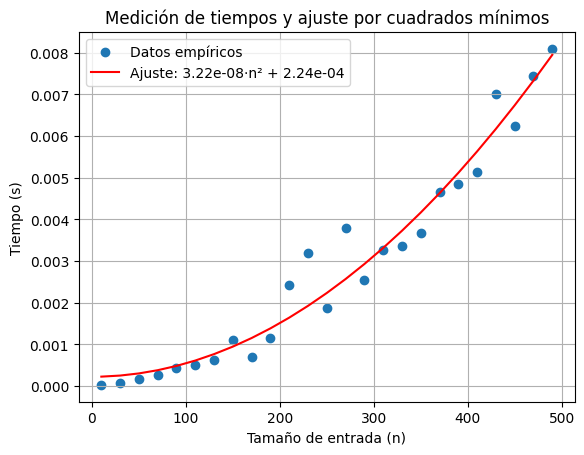

In [6]:
import numpy as np
import matplotlib.pyplot as plt

x = np.array(list(tiempos.keys()))
y = np.array(list(tiempos.values()))

# Ajuste por cuadrados mínimos para y = a * x^2 + b
X = np.vstack([x**2, np.ones_like(x)]).T
a, b = np.linalg.lstsq(X, y, rcond=None)[0]

# Graficamos
plt.scatter(x, y, label="Datos empíricos")
plt.plot(x, a * x**2 + b, color="red", label=f"Ajuste: {a:.2e}·n² + {b:.2e}")
plt.xlabel("Tamaño de entrada (n)")
plt.ylabel("Tiempo (s)")
plt.title("Medición de tiempos y ajuste por cuadrados mínimos")
plt.legend()
plt.grid(True)
plt.show()
